In [1]:
from shaq.cost_model import LatCostModel
from shaq.partitioner import gen_config
import numpy as np 
global_bz = gen_config.global_bz
micro_bz = gen_config.micro_bz
s = gen_config.s
n = gen_config.n

profiled_result_folder = '/workspace/qpipe/scripts/lat_profiled_result/'
device_names = ['Tesla_V100-SXM2-32GB', 'NVIDIA_A100-SXM4-40GB', 'Tesla_P100-PCIE-12GB']
lat_cost_model = LatCostModel(device_names)
lat_cost_model.update_profiled_result(profiled_result_folder)
lat_cost_model.fit_regression_cost_model()
lat_cost_model.load_regression_cost_model()
lat_cost_model.verbose_regression_names()


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /opt/conda/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)
/opt/conda/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/usr/local/cuda/lib64/libcudart

Est model:  Tesla_V100-SXM2-32GB_2_9216_36864_3.pkl
prefill MSE: 31.7105|decode MSE: 0.0190|
Est model:  Tesla_V100-SXM2-32GB_2_9216_36864_4.pkl
prefill MSE: 18.0841|decode MSE: 0.0329|
Est model:  Tesla_V100-SXM2-32GB_2_9216_36864_8:tc-li.pkl
prefill MSE: 2.5541|decode MSE: 0.0561|
Est model:  Tesla_V100-SXM2-32GB_2_9216_36864_16.pkl
prefill MSE: 263.9227|decode MSE: 0.0038|
Est model:  Tesla_V100-SXM2-32GB_2_7168_28672_3.pkl
prefill MSE: 15.5508|decode MSE: 0.0747|
Est model:  Tesla_V100-SXM2-32GB_2_7168_28672_4.pkl
prefill MSE: 15.3923|decode MSE: 0.1286|
Est model:  Tesla_V100-SXM2-32GB_2_7168_28672_8:tc-li.pkl
prefill MSE: 17.1854|decode MSE: 0.1287|
Est model:  Tesla_V100-SXM2-32GB_2_7168_28672_16.pkl
prefill MSE: 23.7516|decode MSE: 0.0006|
Est model:  Tesla_V100-SXM2-32GB_2_14336_57344_3.pkl
prefill MSE: 244.1874|decode MSE: 0.1617|
Est model:  Tesla_V100-SXM2-32GB_2_14336_57344_4.pkl
prefill MSE: 292.3369|decode MSE: 0.1692|
Est model:  Tesla_V100-SXM2-32GB_2_14336_57344_8:tc-

In [9]:
import os
import pandas as pd
groud_truth_folder = './gtruth'
files = os.listdir(groud_truth_folder)

groud_t_A100 = pd.DataFrame()
groud_t_P100 = pd.DataFrame()
groud_t_V100 = pd.DataFrame()

for file in files:
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(groud_truth_folder, file))
        if 'A100' in file:
            groud_t_A100 = pd.concat([groud_t_A100, df], ignore_index=True)
        elif 'P100' in file:
            groud_t_P100 = pd.concat([groud_t_P100, df], ignore_index=True)
        elif 'V100' in file:
            groud_t_V100 = pd.concat([groud_t_V100, df], ignore_index=True)

In [17]:
sample_nums = 50
# sample 50 from the each groud_t
sample_nums = 50
groud_t_A100_sample = groud_t_A100.sample(n=sample_nums)
groud_t_P100_sample = groud_t_P100.sample(n=sample_nums)
groud_t_V100_sample = groud_t_V100.sample(n=sample_nums)

In [18]:
from shaq.partitioner.helper import (
    lat_prediction
)
h1, h2 = 7168, 28672
# test
D_name, b, s, i, bit = 'Tesla_V100-SXM2-32GB', 2, 128, 0, 4
predict_lat = lat_cost_model.predict_same_bit(D_name, b, s, i, h1, h2, bit)
groud_lat = lat_cost_model.fetch_lat(D_name, 2, b, s, i, h1, h2, bit)
print(predict_lat, groud_lat)

141.38701688168624 140.51676988601685


In [24]:
def get_ground_and_predicts(groud_t, device_name = 'NVIDIA_A100-SXM4-40GB'):
    shard = 2
    predict_points = []
    ground_points = []
    for index, row in groud_t.iterrows():
        batch_size = row['batch_size']
        s = row['input_seq_length']
        past_seq_length = row['past_seq_length']
        h1, h2 = row['h1'], row['h2']
        bit = row['bit']
        lat = row['lat_avg']
        ground_points.append(lat)
        predict_points.append(lat_cost_model.predict_same_bit(device_name, batch_size, s, past_seq_length, h1, h2, bit))
    sorted_points = sorted(zip(ground_points, predict_points))
    ground_points, predict_points = zip(*sorted_points)
    return ground_points, predict_points


In [25]:
ground_points_A, predict_points_A = get_ground_and_predicts(groud_t_A100_sample, 'NVIDIA_A100-SXM4-40GB')
ground_points_P, predict_points_P = get_ground_and_predicts(groud_t_P100_sample, 'Tesla_P100-PCIE-12GB')
ground_points_V, predict_points_V = get_ground_and_predicts(groud_t_V100_sample, 'Tesla_V100-SXM2-32GB')

In [26]:
import numpy as np
all_points = ground_points_A + ground_points_P + ground_points_V
all_predicts = predict_points_A + predict_points_P + predict_points_V
error_percent = np.mean(np.abs((np.array(all_points) - np.array(all_predicts)) / np.array(all_points))) * 100

In [27]:
error_percent

6.173247919099535

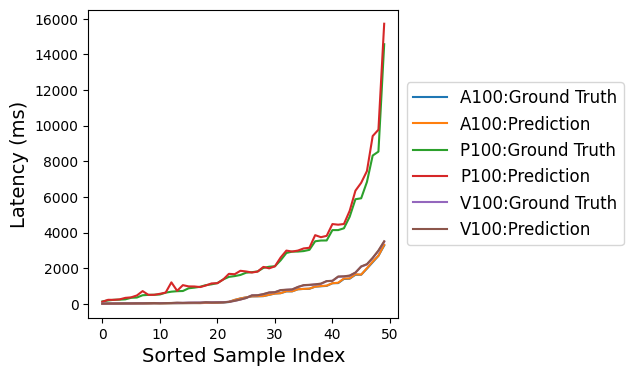

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 4))  # increase figure size here

ax.plot(ground_points_A, label='A100:Ground Truth')
ax.plot(predict_points_A, label='A100:Prediction')
ax.plot(ground_points_P, label='P100:Ground Truth')
ax.plot(predict_points_P, label='P100:Prediction')
ax.plot(ground_points_V, label='V100:Ground Truth')
ax.plot(predict_points_V, label='V100:Prediction')
ax.set_xlabel('Sorted Sample Index', fontsize=14)  # increase x-axis label size here
ax.set_ylabel('Latency (ms)', fontsize=14)  # increase y-axis label size here
# ax.set_title('Ground vs Predicted Points for Device {} and Shard {}'.format(device_name, shard), fontsize=16)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)  # move legend to the right and increase font size here
plt.savefig('lat_cost_model.png', bbox_inches='tight')  # use bbox_inches to prevent legend from being cut off
plt.show()